## Image-Sweep

### Dataset preperation

In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm

# Data Augmentation

In [ ]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal_and_vertical'),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.1),
      #tf.keras.layers.RandomCrop(1024, 1024),
    ])

In [ ]:
directory = "data/"

BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 824 files belonging to 2 classes.
Using 660 files for training.
Found 824 files belonging to 2 classes.
Using 164 files for validation.


2024-05-15 19:45:29.321004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


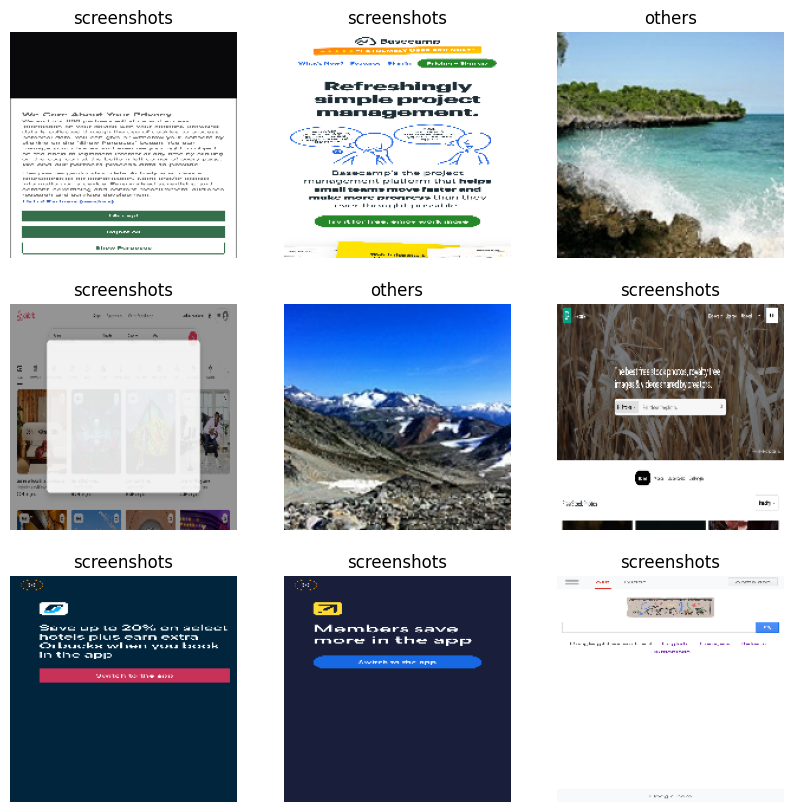

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_dataset = validation_dataset.take(val_batches // 5)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 5
Number of test batches: 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-05-15 19:45:30.227981: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(32, 6, 6, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
#base_model.summary()

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_192            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.3971 - loss: 1.2881
initial loss: 1.30
initial accuracy: 0.38


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.3996 - loss: 1.2714 - val_accuracy: 0.4091 - val_loss: 0.8927
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.4209 - loss: 0.9292 - val_accuracy: 0.5758 - val_loss: 0.6566
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.4649 - loss: 0.7837 - val_accuracy: 0.7652 - val_loss: 0.5518
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.6306 - loss: 0.6798 - val_accuracy: 0.8409 - val_loss: 0.5046
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.6472 - loss: 0.6826 - val_accuracy: 0.8712 - val_loss: 0.4741
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.6044 - loss: 0.6605 - val_accuracy: 0.8788 - val_loss: 0.4470
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.6659 - loss: 0.6325 - val_accuracy: 0.8939 - val_loss: 0.4243
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.7202 - loss: 0.5627 - val_accuracy: 0.

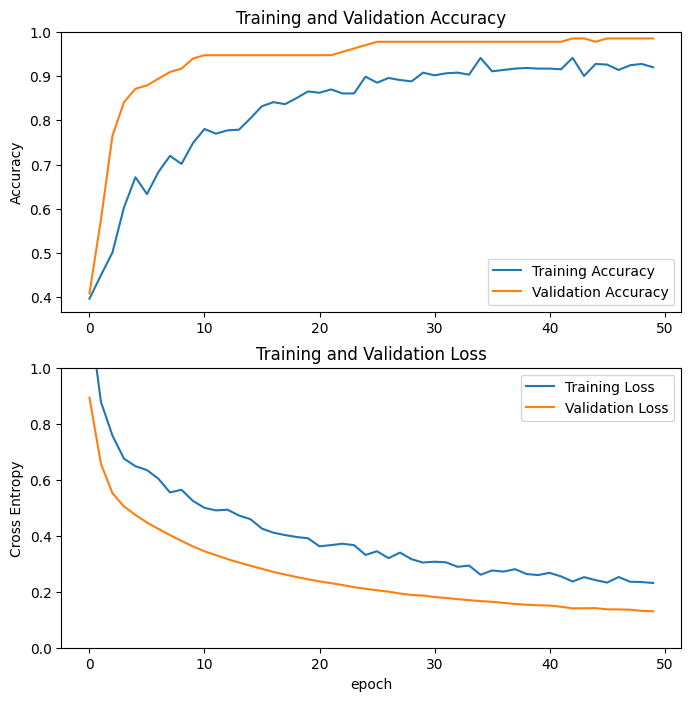

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9375 - loss: 0.1972
Test accuracy : 0.9375


Predictions:
 [0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0]
Labels:
 [0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0]


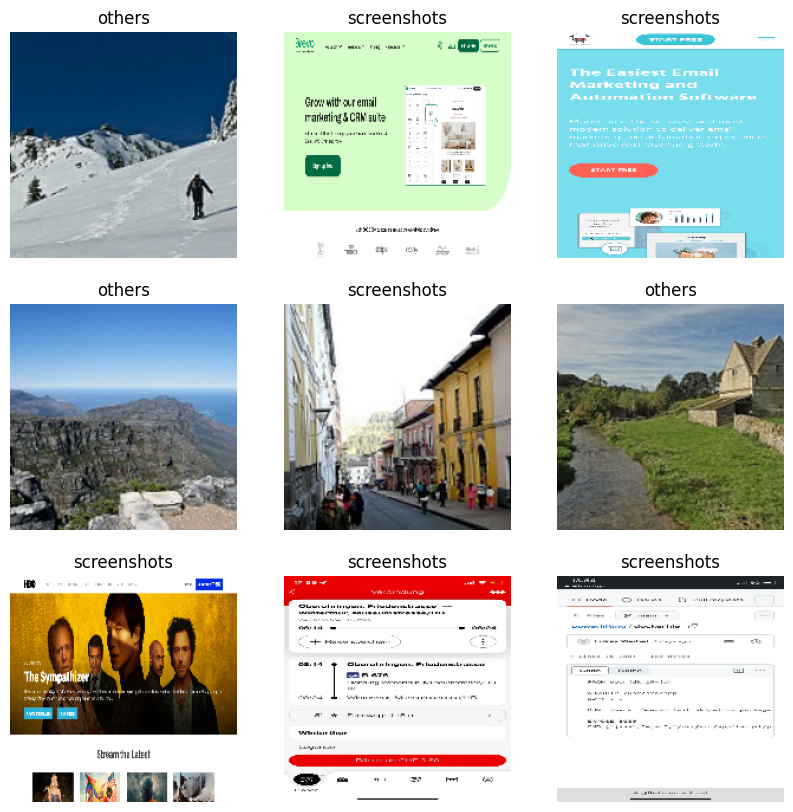

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Get model predictions. Note: Do not flatten here.
predictions = model.predict_on_batch(image_batch)

# Convert predictions to class indices based on the threshold
predicted_class_index = (predictions > 0.5).astype(int)

# Print the predictions and labels horizontally
print('Predictions:\n', predicted_class_index.flatten())
print('Labels:\n', label_batch.flatten())

# Optionally, visualize predictions with images
batch_size = image_batch.shape[0]  # Get the actual batch size
num_to_plot = min(batch_size, 9)  # Plot up to 9 images or fewer if batch_size is less than 9
plt.figure(figsize=(10, 10))
for i in range(num_to_plot):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_class_index[i][0]])  # Ensure correct indexing in class_names
    plt.axis("off")
plt.show()

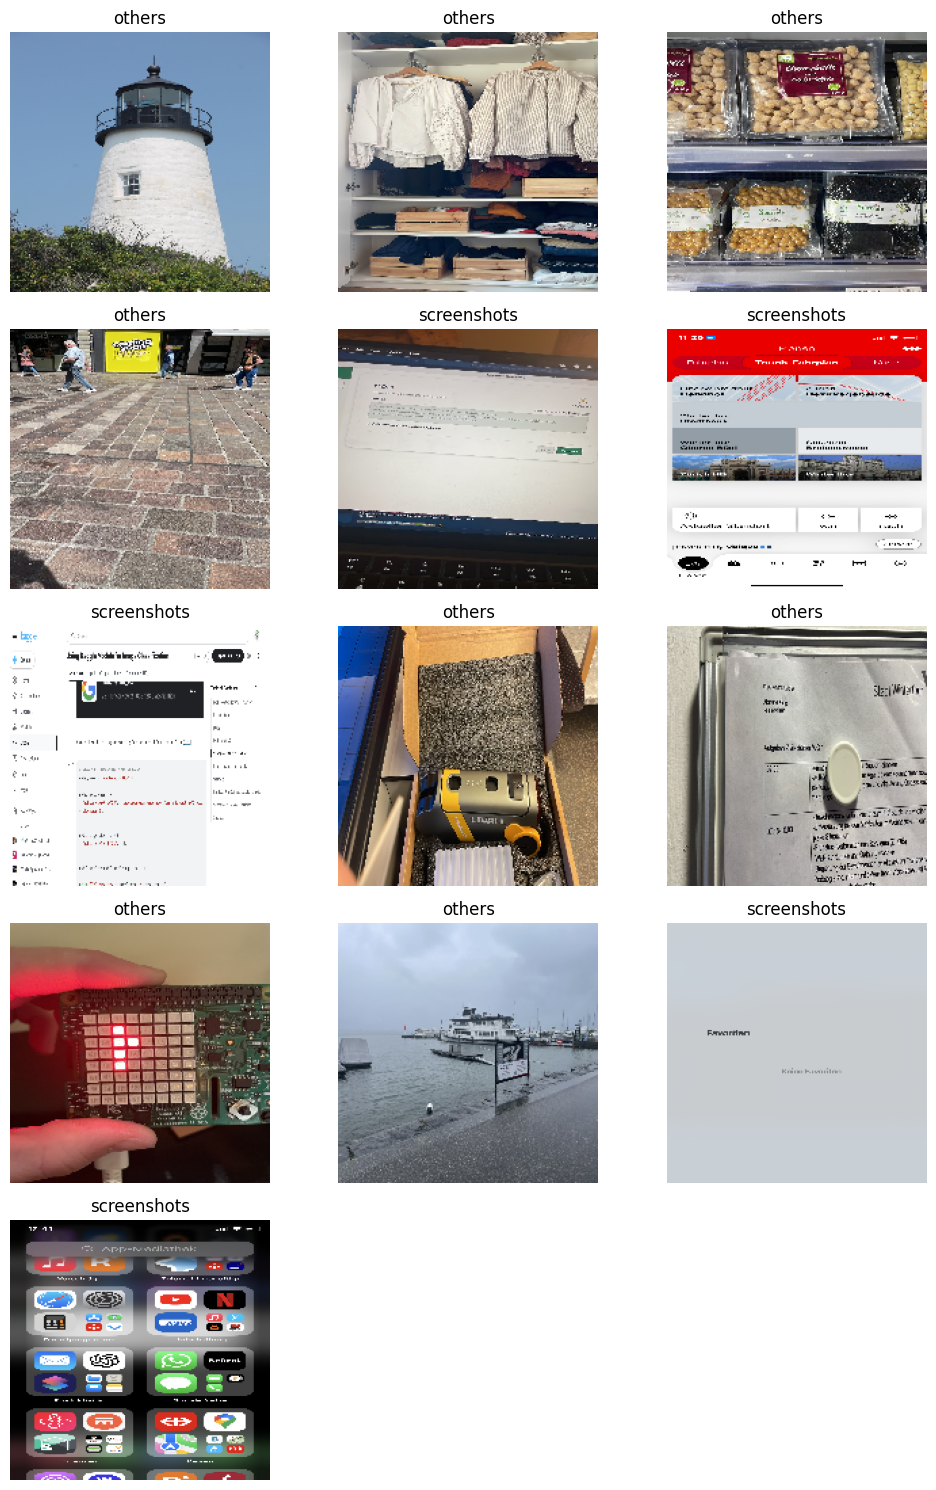

In [ ]:
# This code classifies all pictures in the "examples" folder

# Directory containing the images
directory = "examples/"

# List to store images and predictions
images = []
predictions = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    img_path = os.path.join(directory, filename)
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Check file extension
        # Load and preprocess the image
        img = tf.keras.utils.load_img(img_path, target_size=(192, 192))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Add the batch dimension

        # Get model predictions
        prediction = model.predict_on_batch(img_array)

        # Convert prediction to class index
        predicted_class_index = (prediction > 0.5).astype(int)
        predicted_class = class_names[predicted_class_index[0][0]]  # Correct class name fetching

        # Store image and prediction
        images.append(img)
        predictions.append(predicted_class)

# Determine the size of the grid
num_images = len(images)
cols = 3  # Define number of columns
rows = (num_images + cols - 1) // cols  # Calculate required number of rows

# Create a figure with subplots
plt.figure(figsize=(10, 3 * rows))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.title(predictions[i])
    plt.axis("off")
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [4]:
input("heekkoo")